### Time Series Workshop 
# 5. Online Retail &#x1F4B0;: Forecasting Challenge

Now it's your turn! 

Here, we provide some guard rails to get you started. Try to
- explore the data
- Apply previously discussed techniques for pre-processing and feature engineering
- Forecast the next week sales for a pre-defined test set
- Evaluate the quality of your forecast

In [1]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from timeseries.data import load_air_quality
from timeseries.utils import print_metrics
from sklearn.linear_model import Lasso
from feature_engine.creation import CyclicalFeatures
from sklearn.pipeline import Pipeline
from timeseries import preprocessing as pp
from sklearn.preprocessing import FunctionTransformer as ftrf

DATA_DIR = Path("..") / Path("data")

## Load data

In [2]:
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"
df = pd.read_csv(url)

In [3]:
df

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068
...,...,...
288,2016-01-01,400928
289,2016-02-01,413554
290,2016-03-01,460093
291,2016-04-01,450935


In [2]:
FILE_PATH = DATA_DIR / "air_quality_processed.csv"

df_in = pd.read_csv(
    FILE_PATH,
    parse_dates=["date_time"],
    index_col=["date_time"],
)
df_in.head(2)


,co_sensor,month,week,day,day_of_week,hour,is_weekend,co_sensor_lag_1,co_sensor_lag_2,co_sensor_lag_3,...,co_sensor_win_max,co_sensor_win_std,humidity_win_mean,humidity_win_min,humidity_win_max,humidity_win_std,month_sin,month_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,1065.0,4,15,5,0,0,0,1188.0,1196.0,1113.0,...,1420.0,130.064599,53.84,44.6,60.8,6.854415,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,999.0,4,15,5,0,1,0,1065.0,1188.0,1196.0,...,1366.0,114.535147,58.08,48.9,65.8,6.239151,0.866025,-0.5,0.269797,0.962917


In [3]:
SPLIT_DATE = "2005-02-01"
TARGET_COL = "co_sensor"

X_train = df_in[df_in.index <= SPLIT_DATE]
X_test = df_in[df_in.index > SPLIT_DATE]

y_train = X_train.pop(TARGET_COL)
y_test = X_test.pop(TARGET_COL)

train_ratio = len(y_train) / len(df_in)
test_ratio = len(y_test) / len(df_in)

print(f"Train vs. test ratios: {train_ratio:.2%} vs. {test_ratio:.2%}")


Train vs. test ratios: 86.02% vs. 13.98%


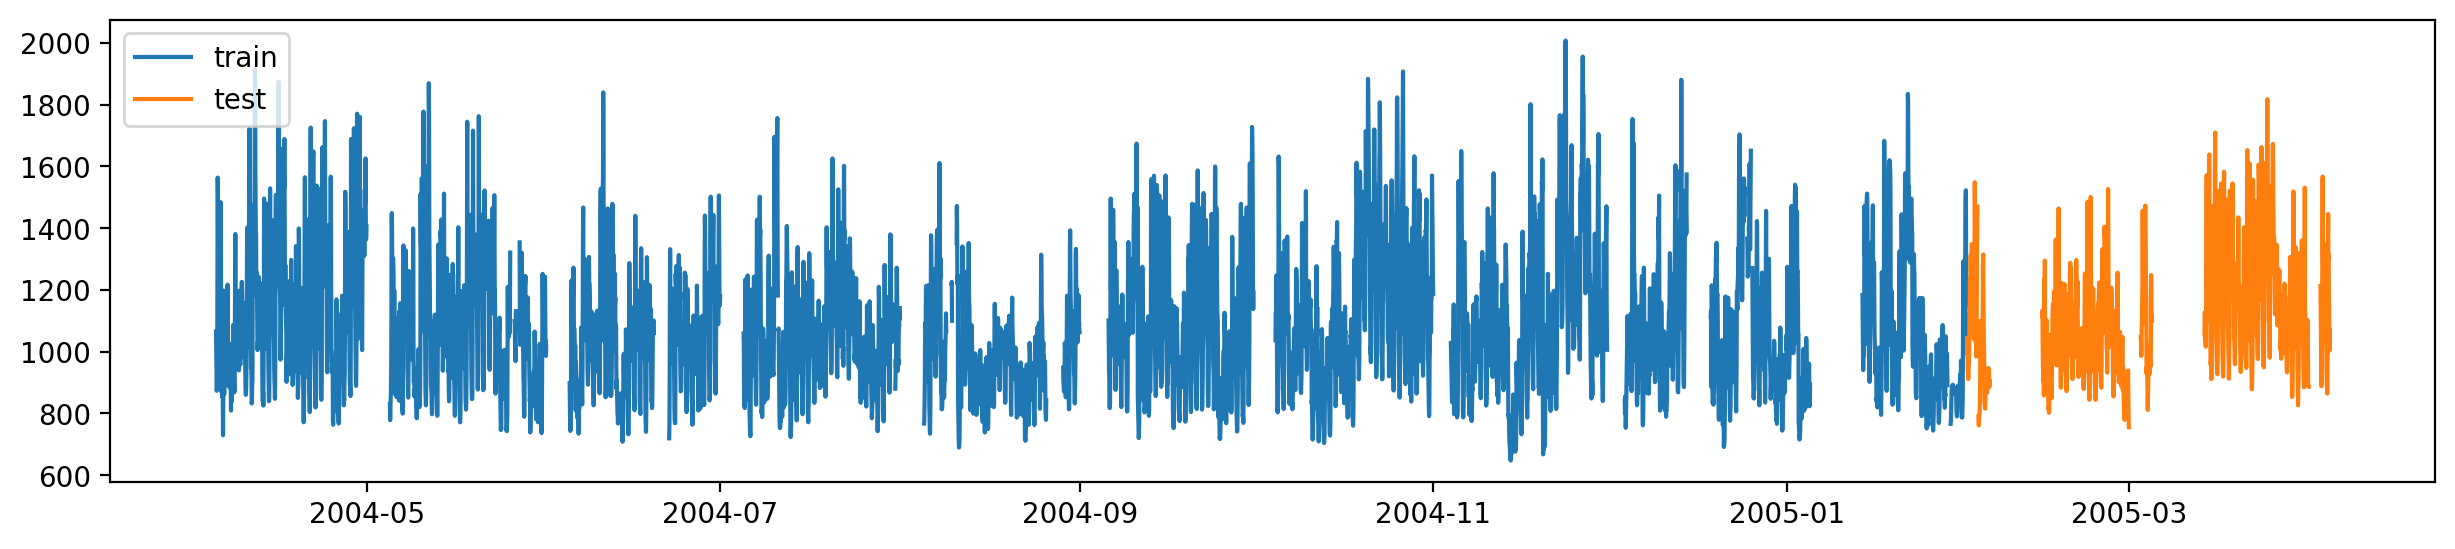

In [4]:
train_range = pd.DataFrame(
    index=pd.date_range(y_train.index.min(), y_train.index.max(), freq="1H")
)
test_range = pd.DataFrame(
    index=pd.date_range(y_test.index.min(), y_test.index.max(), freq="1H")
)

y_train_plt = train_range.merge(y_train, left_index=True, right_index=True, how="left")
y_test_plt = test_range.merge(y_test, left_index=True, right_index=True, how="left")

_, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(y_train_plt, label="train")
_ = ax.plot(y_test_plt, label="test")
_ = plt.legend(loc="upper left")

# Random Forest Regressor

In [5]:
FOREST_FEATURES = [
    "month",
    "week",
    "day",
    "day_of_week",
    "hour",
    "is_weekend",
    "co_sensor_lag_1",
    "co_sensor_lag_2",
    "co_sensor_lag_3",
    "co_sensor_lag_24",
    "humidity_lag_1",
    "humidity_lag_2",
    "humidity_lag_3",
    "humidity_lag_24",
    "co_sensor_win_mean",
    "co_sensor_win_min",
    "co_sensor_win_max",
    "co_sensor_win_std",
    "humidity_win_mean",
    "humidity_win_min",
    "humidity_win_max",
    "humidity_win_std",
]

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=0,
)
rf_model.fit(X_train[FOREST_FEATURES], y_train)

y_pred = rf_model.predict(X_test[FOREST_FEATURES])
print_metrics(y_test, y_pred)

RMSE:      87.94
MAE:       61.63
MAPE:       5.32%


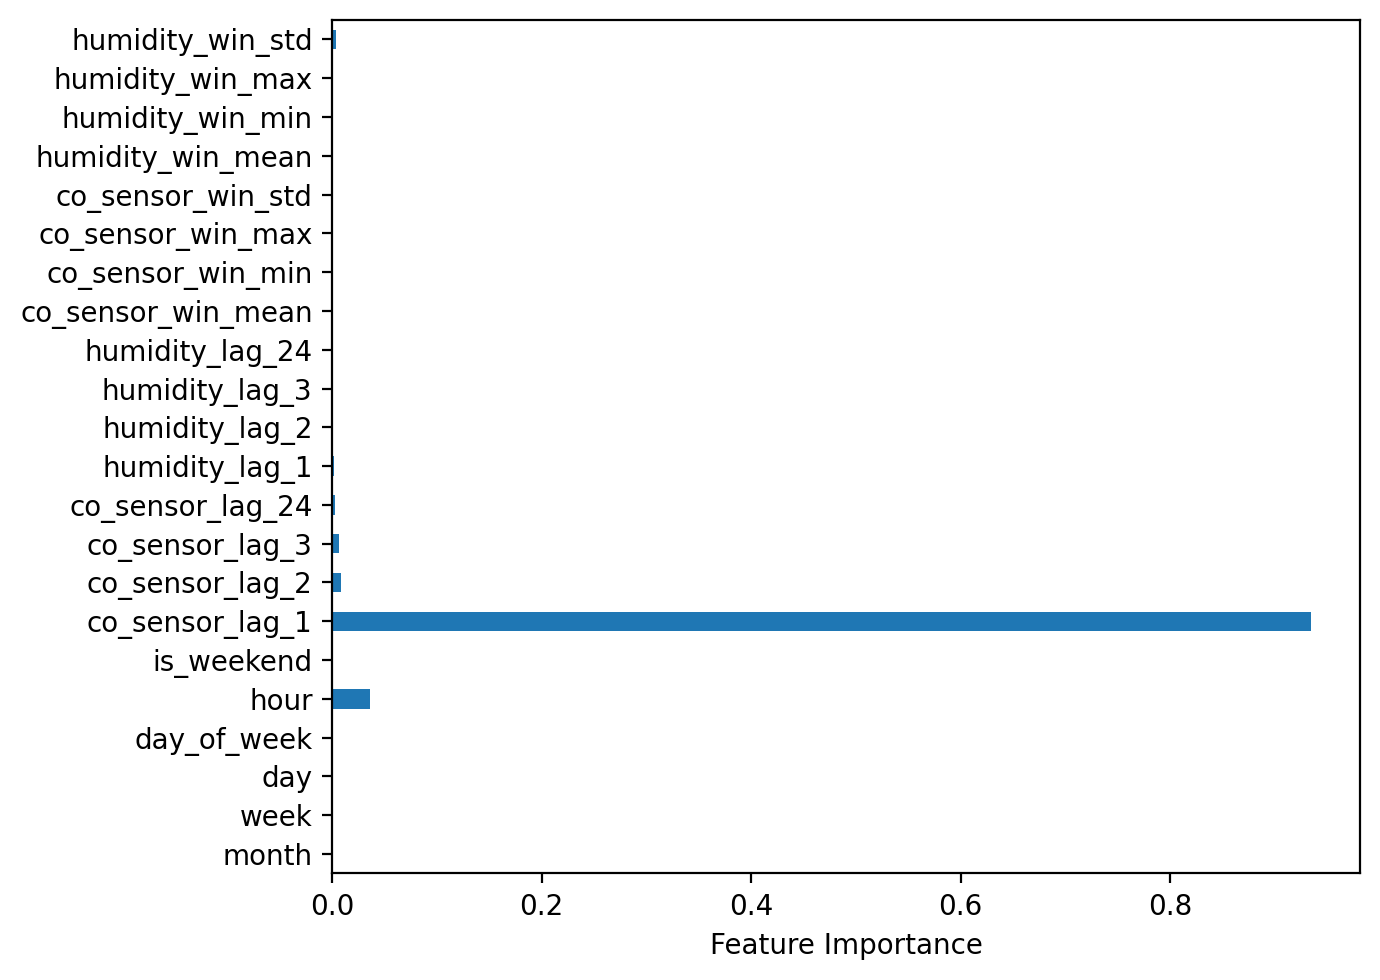

In [6]:
rf_importances = pd.Series(rf_model.feature_importances_, index=FOREST_FEATURES)
_ = rf_importances.plot.barh(figsize=(7, 5))
_ = plt.xlabel("Feature Importance")
_ = plt.tight_layout()

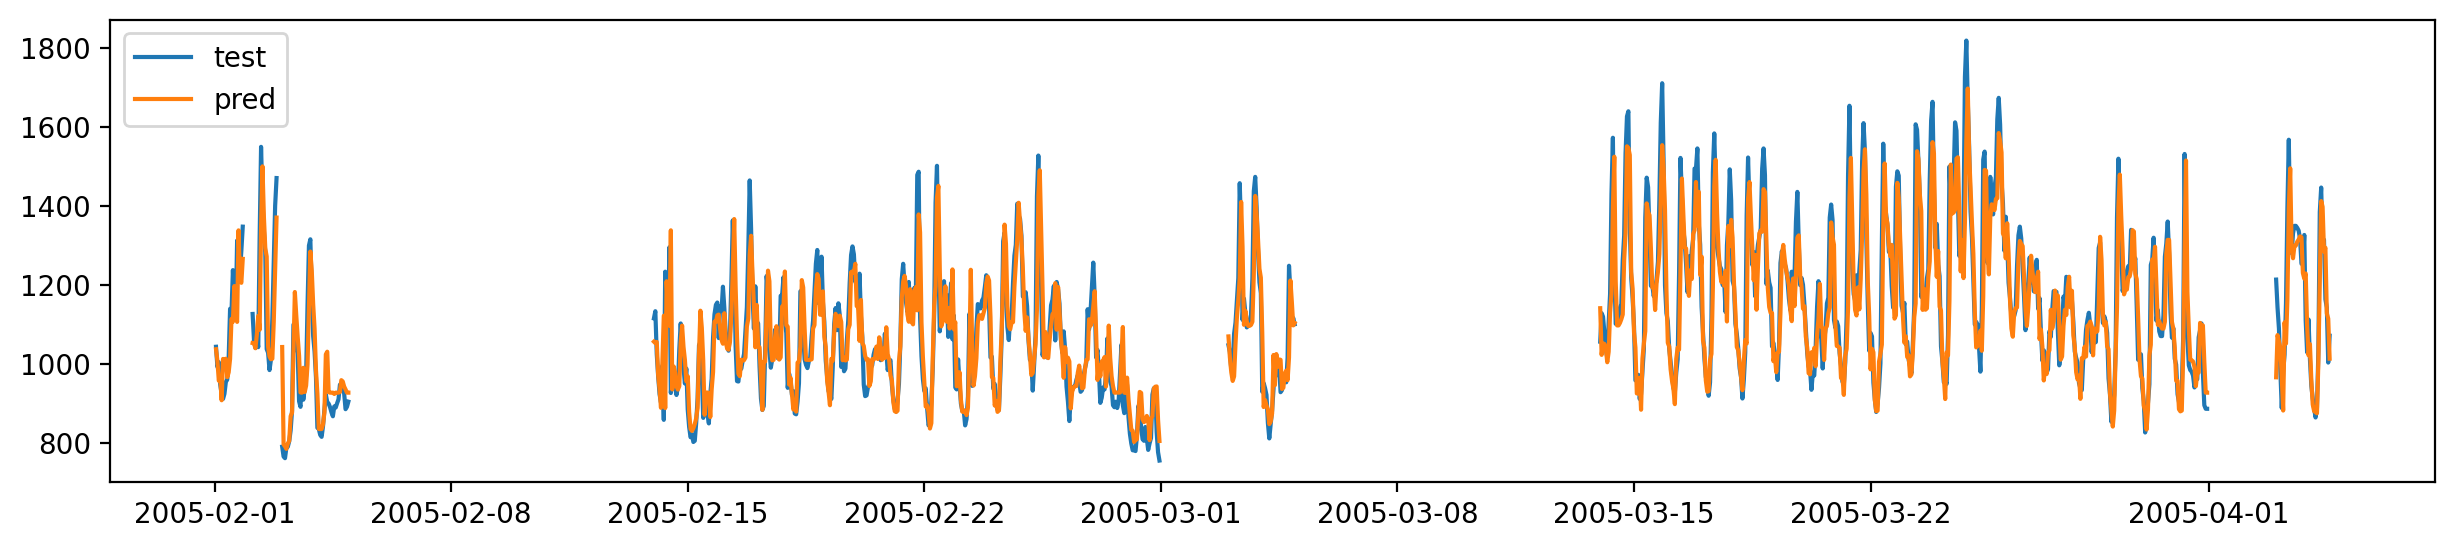

In [7]:
y_pred_plt = test_range.merge(
    pd.Series(y_pred, index=y_test.index, name="pred"),
    left_index=True,
    right_index=True,
    how="left",
)

_, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(y_test_plt, label="test")
_ = ax.plot(y_pred_plt, label="pred")
_ = plt.legend(loc="upper left")

# Linear Regression

In [12]:
LINEAR_FEATURES = [
    "is_weekend",
    "co_sensor_lag_1",
    "co_sensor_lag_2",
    "co_sensor_lag_3",
    "co_sensor_lag_24",
    "humidity_lag_1",
    "humidity_lag_2",
    "humidity_lag_3",
    "humidity_lag_24",
    "co_sensor_win_mean",
    "co_sensor_win_min",
    "co_sensor_win_max",
    "co_sensor_win_std",
    "humidity_win_mean",
    "humidity_win_min",
    "humidity_win_max",
    "humidity_win_std",
    "month_sin",
    "month_cos",
    "hour_sin",
    "hour_cos",
]

linear_model = Lasso(alpha=2, random_state=0)
linear_model.fit(X_train[LINEAR_FEATURES], y_train)

y_pred = linear_model.predict(X_test[LINEAR_FEATURES])
print_metrics(y_test, y_pred)

KeyError: "['humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_24', 'co_sensor_win_mean', 'co_sensor_win_max', 'humidity_win_mean', 'humidity_win_min', 'humidity_win_max', 'humidity_win_std'] not in index"

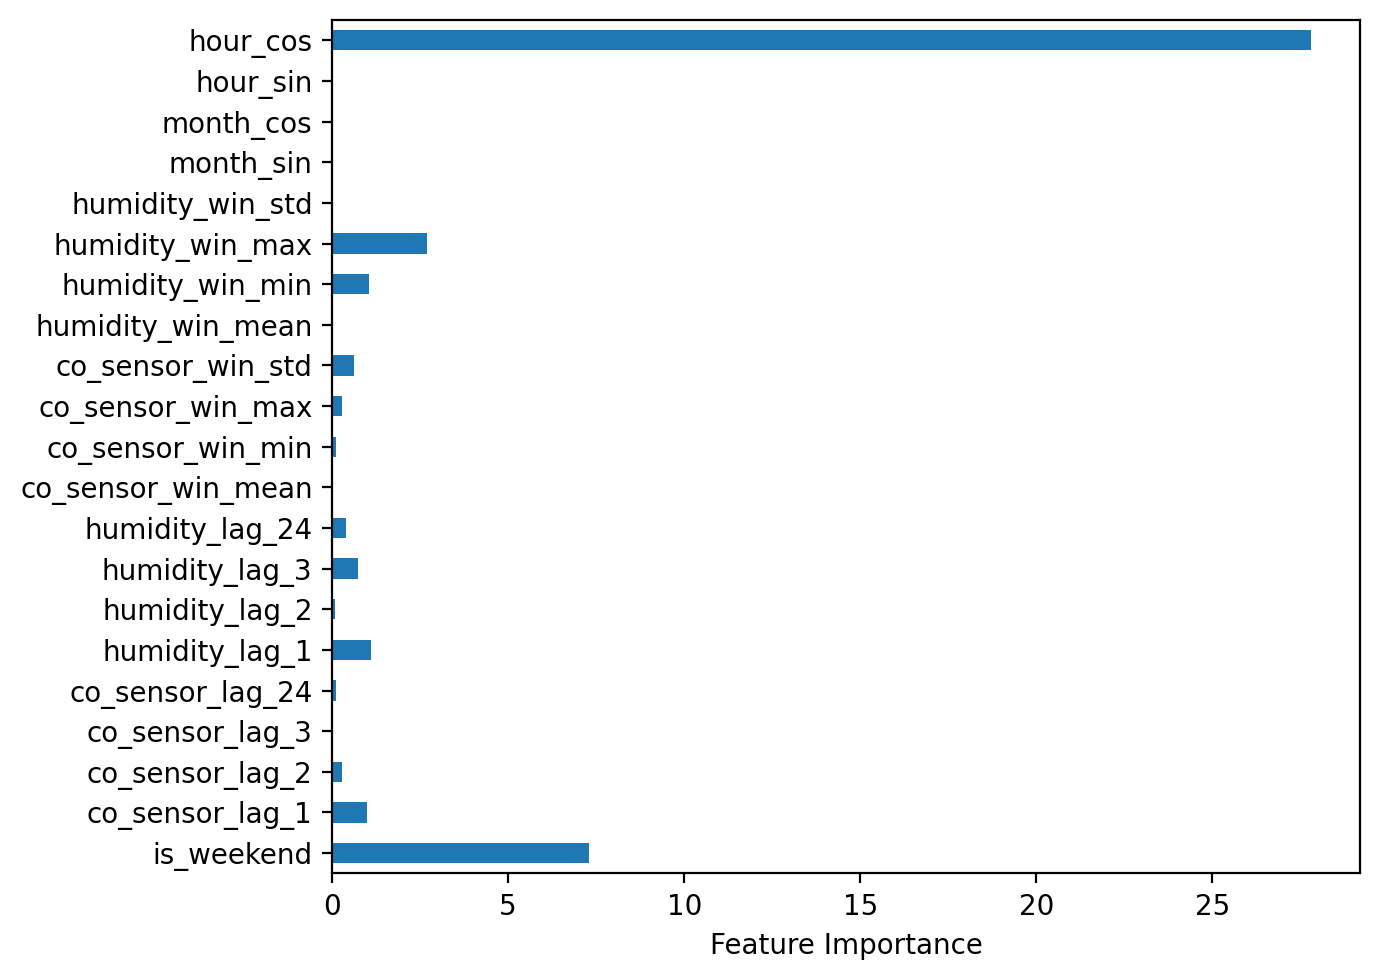

In [ ]:
coefs = pd.Series(np.abs(linear_model.coef_), index=LINEAR_FEATURES)
_ = coefs.plot.barh(figsize=(7, 5))
_ = plt.xlabel("Feature Importance")
_ = plt.tight_layout()

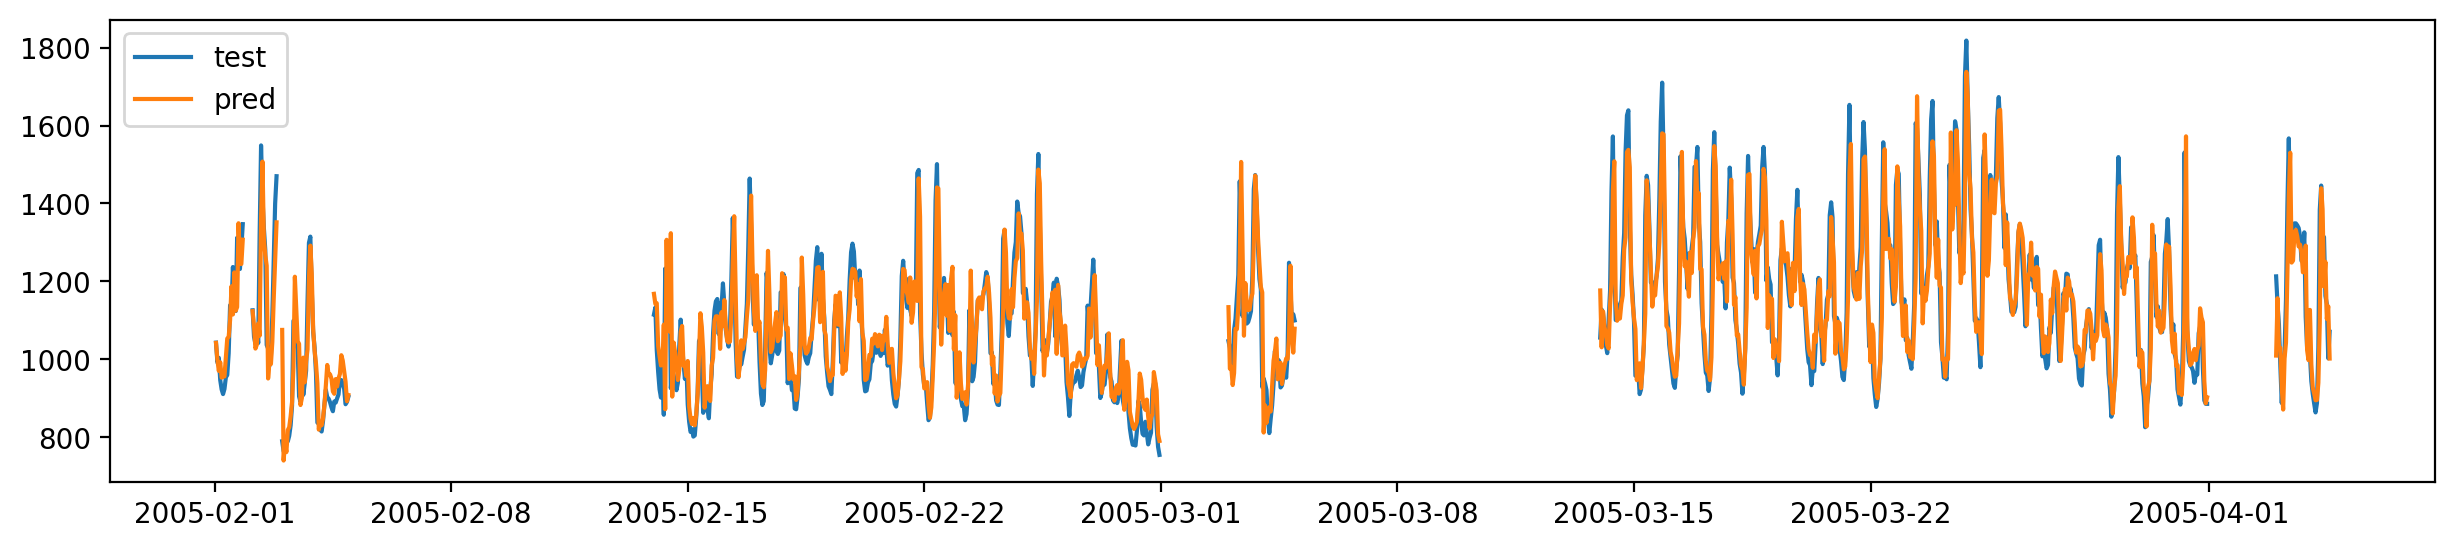

In [10]:
y_pred_plt = test_range.merge(
    pd.Series(y_pred, index=y_test.index, name="pred"),
    left_index=True,
    right_index=True,
    how="left",
)

_, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(y_test_plt, label="test")
_ = ax.plot(y_pred_plt, label="pred")
_ = plt.legend(loc="upper left")

# Putting it all together
This endless stream of notebook cells doesn't exactly correspond to the usual best practices.

Here's an example of the whole thing put together in a single cell:

In [19]:
# Define params:
FILE_PATH = DATA_DIR / "air_quality.csv"
SPLIT_DATE = "2005-02-01"
INPUT_COLS = ["co_sensor", "humidity"]
CYCLIC_COLS = ["month", "hour"]
TARGET_COL = "co_sensor"
FEATURE_COLS = [
    TARGET_COL,
    "is_weekend",
    "co_sensor_lag_1",
    "co_sensor_lag_2",
    "co_sensor_lag_3",
    "co_sensor_lag_24",
    "humidity_lag_1",
    "humidity_lag_24",
    "co_sensor_win_min",
    "co_sensor_win_std",
    "humidity_win_max",
    "month_sin",
    "month_cos",
    "hour_sin",
    "hour_cos",
]

# Load original data:
df_in = load_air_quality(FILE_PATH)[INPUT_COLS]
df_in.head()

# Define preprocessing pipeline:
preprocessing_steps = [
    ("remove_negative_values", ftrf(pp.remove_negative_values)),
    ("time_features", ftrf(pp.time_features)),
    (
        "lag_features",
        ftrf(pp.lag_features, kw_args={"columns": INPUT_COLS, "lags": [1, 2, 3, 24]}),
    ),
    ("window_features", ftrf(pp.window_features, kw_args={"columns": INPUT_COLS})),
    (
        "cyclical_features",
        CyclicalFeatures(
            variables=CYCLIC_COLS,
            drop_original=False,
        ),
    ),
    ("select_cols", ftrf(pp.select_columns, kw_args={"columns": FEATURE_COLS})),
    ("remove_na_values", ftrf(pp.remove_na)),
]
preprocessing_pipe = Pipeline(preprocessing_steps)

# Apply preprocessing pipeline:
df_processed = preprocessing_pipe.fit_transform(df_in)

# Train-test split:
X_train = df_processed[df_processed.index <= SPLIT_DATE]
X_test = df_processed[df_processed.index > SPLIT_DATE]
y_train = X_train.pop(TARGET_COL)
y_test = X_test.pop(TARGET_COL)

# Fit simple model:
linear_model = Lasso(alpha=5, random_state=0)
linear_model.fit(X_train, y_train)

# Predict:
y_pred = linear_model.predict(X_test)
print_metrics(y_test, y_pred)

RMSE:      85.45
MAE:       60.42
MAPE:       5.28%


Now this looks pretty amazing and all. It's just a one-hour forecast, though. Anyways, amazing! &#x1F973;

But what should we have done first?

## Did we forget something? &#x1F6A8;
